## Import library

In [102]:
import lightgbm as lgb

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd
import gc

In [103]:
def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    y_ohe = pd.get_dummies(y_true)
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

In [106]:
def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')
    y_ohe = pd.get_dummies(y_true)
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    y_p_log = np.log(y_p)
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False

## Data import

In [107]:
#train_gal = pd.read_pickle('../input/train_gal_20181214.pickle')
#test_gal = pd.read_pickle('../input/test_gal_20181214.pickle')
train = pd.read_pickle('../input/train_ex_gal_20181214.pickle')
test = pd.read_pickle('../input/test_ex_gal_20181214.pickle')

In [108]:
train_oof = pd.read_pickle('../input/oof_result_20181216_v3_simple.pickle') # Best:1216(0.947)
test_oof = pd.read_pickle('../input/preds_result_20181216_v3_simple.pickle') # Best:1216(0.947)

In [109]:
train_sixth_band = pd.read_pickle('../input/train_sixth_byband.pickle')
test_sixth_band = pd.read_pickle('../input/test_sixth_byband.pickle')

In [110]:
train_fix_band_0_stats = pd.read_pickle('../input/train_band_0_fix_stats.pickle')
test_fix_band_0_stats = pd.read_pickle('../input/test_band_0_fix_stats.pickle')
train_fix_band_1_stats = pd.read_pickle('../input/train_band_1_fix_stats.pickle')
test_fix_band_1_stats = pd.read_pickle('../input/test_band_1_fix_stats.pickle')
#train_fix_band_2_stats = pd.read_pickle('../input/train_band_2_fix_stats.pickle')
#test_fix_band_2_stats = pd.read_pickle('../input/test_band_2_fix_stats.pickle')

In [111]:
train_length = pd.read_pickle('../input/train_length.pickle')
test_length = pd.read_pickle('../input/test_length.pickle')

train_band_length = pd.read_pickle('../input/train_band_length.pickle')
test_band_length = pd.read_pickle('../input/test_band_length.pickle')

In [112]:
train = pd.merge(train,train_oof,on='object_id',how='left')
#train = pd.merge(train,train_sixth_band,on='object_id',how='left')
train = pd.merge(train,train_length,on='object_id',how='left')
train = pd.merge(train,train_band_length,on='object_id',how='left')
train = pd.merge(train,train_fix_band_0_stats ,on='object_id',how='left')
train = pd.merge(train,train_fix_band_1_stats ,on='object_id',how='left')
#train = pd.merge(train,train_fix_band_2_stats ,on='object_id',how='left')

In [113]:
test = pd.merge(test,test_oof,on='object_id',how='left')
#test = pd.merge(test,test_sixth_band,on='object_id',how='left')
test = pd.merge(test,test_length,on='object_id',how='left')
test = pd.merge(test,test_band_length,on='object_id',how='left')
test = pd.merge(test,test_fix_band_0_stats ,on='object_id',how='left')
test = pd.merge(test,test_fix_band_1_stats ,on='object_id',how='left')
#test = pd.merge(test,test_fix_band_2_stats ,on='object_id',how='left')

In [114]:
print(train.shape)
print(test.shape)

(7848, 231)
(3492890, 230)


In [115]:
train['flux__longest_strike_above_mean'] = train['flux__longest_strike_above_mean'] / train['count']
train['flux__number_crossing_m__m_1'] = train['flux__number_crossing_m__m_1'] / train['count']

train['0__longest_strike_above_mean'] = train['0__longest_strike_above_mean'] / train['passband_count_0']
train['1__longest_strike_above_mean'] = train['1__longest_strike_above_mean'] / train['passband_count_1']
train['2__longest_strike_above_mean'] = train['2__longest_strike_above_mean'] / train['passband_count_2']
train['3__longest_strike_above_mean'] = train['3__longest_strike_above_mean'] / train['passband_count_3']
train['4__longest_strike_above_mean'] = train['4__longest_strike_above_mean'] / train['passband_count_4']
train['5__longest_strike_above_mean'] = train['5__longest_strike_above_mean'] / train['passband_count_5']

train['0__number_crossing_m__m_1'] = train['0__number_crossing_m__m_1'] / train['passband_count_0']
train['1__number_crossing_m__m_1'] = train['1__number_crossing_m__m_1'] / train['passband_count_1']
train['2__number_crossing_m__m_1'] = train['2__number_crossing_m__m_1'] / train['passband_count_2']
train['3__number_crossing_m__m_1'] = train['3__number_crossing_m__m_1'] / train['passband_count_3']
train['4__number_crossing_m__m_1'] = train['4__number_crossing_m__m_1'] / train['passband_count_4']
train['5__number_crossing_m__m_1'] = train['5__number_crossing_m__m_1'] / train['passband_count_5']

In [116]:
test['flux__longest_strike_above_mean'] = test['flux__longest_strike_above_mean'] / test['count']
test['flux__number_crossing_m__m_1'] = test['flux__number_crossing_m__m_1'] / test['count']

test['0__longest_strike_above_mean'] = test['0__longest_strike_above_mean'] / test['passband_count_0']
test['1__longest_strike_above_mean'] = test['1__longest_strike_above_mean'] / test['passband_count_1']
test['2__longest_strike_above_mean'] = test['2__longest_strike_above_mean'] / test['passband_count_2']
test['3__longest_strike_above_mean'] = test['3__longest_strike_above_mean'] / test['passband_count_3']
test['4__longest_strike_above_mean'] = test['4__longest_strike_above_mean'] / test['passband_count_4']
test['5__longest_strike_above_mean'] = test['5__longest_strike_above_mean'] / test['passband_count_5']

test['0__number_crossing_m__m_1'] = test['0__number_crossing_m__m_1'] / test['passband_count_0']
test['1__number_crossing_m__m_1'] = test['1__number_crossing_m__m_1'] / test['passband_count_1']
test['2__number_crossing_m__m_1'] = test['2__number_crossing_m__m_1'] / test['passband_count_2']
test['3__number_crossing_m__m_1'] = test['3__number_crossing_m__m_1'] / test['passband_count_3']
test['4__number_crossing_m__m_1'] = test['4__number_crossing_m__m_1'] / test['passband_count_4']
test['5__number_crossing_m__m_1'] = test['5__number_crossing_m__m_1'] / test['passband_count_5']

In [117]:
drop_list = ['passband_count_0','passband_count_1','passband_count_2','passband_count_3','passband_count_4','passband_count_5'
             ,'count','count_det','flux_dif','index','flux_mean','flux_mean_detected'
             ,'0__minimum_diff','1__minimum_diff','2__minimum_diff','3__minimum_diff','4__minimum_diff','5__minimum_diff'
             ,'diff_flux__minimum_diff','diff_flux__minimum_diff_det']

In [118]:
train = train.drop(drop_list, axis=1)
test = test.drop(drop_list, axis=1)

In [119]:
def check_null(data):
    print(data.isnull().sum())

pd.set_option('display.max_rows', 500)
#print(check_null(train))
#print(check_null(test))

In [120]:
# add mean → good result

train = train.replace([np.inf, -np.inf], np.nan)
test = test.replace([np.inf, -np.inf], np.nan)

train_mean = train.mean(axis=0)
train.fillna(train_mean, inplace=True)
test = test.fillna(train_mean)

In [121]:
import sys
# check used_momery
print(train.shape,"行×列")
print("train:使用メモリ",round(sys.getsizeof(train) / 1073741824,2),"GB")

print(test.shape,"行×列")
print("test:使用メモリ",round(sys.getsizeof(test) / 1073741824,2),"GB")

(7848, 211) 行×列
train:使用メモリ 0.01 GB
(3492890, 210) 行×列
test:使用メモリ 5.1 GB


## modeling_lgbm

In [122]:
gc.collect()
y = train['target']
del train['target']
del train['object_id'], test['object_id']

In [123]:
import logging


def create_logger():
    logger_ = logging.getLogger('main')
    logger_.setLevel(logging.DEBUG)
    fh = logging.FileHandler('simple_lightgbm_v2.log')
    fh.setLevel(logging.DEBUG)
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    formatter = logging.Formatter('[%(levelname)s]%(asctime)s:%(name)s:%(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    # add the handlers to the logger
    logger_.addHandler(fh)
    logger_.addHandler(ch)


def get_logger():
    return logging.getLogger('main')

In [124]:
from sklearn.model_selection import StratifiedKFold
def train_classifiers(full_train=None, y=None, seed_list=[1,2]):
    
    preds_merge = pd.DataFrame()
    
    for seed_num in seed_list:
        print('------------ seed {} start ------------'.format(seed_num))
        
        folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_num)
        clfs = []
        importances = pd.DataFrame()

        # conclusion:defalut is great!
        lgb_params = {
            'boosting_type': 'gbdt',
            'objective': 'multiclass',
            'num_class': 14,
            'metric': 'multi_logloss',
            'learning_rate': 0.03, #def:0.03
            'subsample': .8,
            'colsample_bytree': .7,
            'reg_alpha': .01,
            'reg_lambda': .01,
            'min_split_gain': 0.01, #def:0.01
            'min_child_weight': 10, # def:10
            #'min_data_in_leaf':50,
            'n_estimators': 4000,
            'silent': -1,
            'verbose': -1,
            'max_depth': 3,
            #'num_leaves': 3, # add
            #'max_bin':31 #add
            #'use_missing': False
        }
        clf = lgb.LGBMClassifier(**lgb_params)

        lgb_selector = SelectFromModel(clf)
        lgb_selector.fit(full_train, y)
        feature_idx = lgb_selector.get_support() 
        feature_name = full_train.columns[feature_idx]
        full_train = full_train[feature_name]

        # Compute weights
        w = y.value_counts()
        weights = {i : np.sum(w) / w[i] for i in w.index}

        oof_preds = np.zeros((len(full_train), np.unique(y).shape[0]))
        
        for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
            trn_x, trn_y = full_train.iloc[trn_], y.iloc[trn_]
            val_x, val_y = full_train.iloc[val_], y.iloc[val_]

            clf = lgb.LGBMClassifier(**lgb_params)
            clf.fit(
                trn_x, trn_y,
                eval_set=[(trn_x, trn_y), (val_x, val_y)],
                eval_metric=lgb_multi_weighted_logloss,
                verbose=1000,
                early_stopping_rounds=50,
                sample_weight=trn_y.map(weights),
                #init_score = init_result.values
            )

            oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
            get_logger().info(multi_weighted_logloss(val_y, clf.predict_proba(val_x, num_iteration=clf.best_iteration_)))

            imp_df = pd.DataFrame()
            imp_df['feature'] = full_train.columns
            imp_df['gain'] = clf.feature_importances_
            imp_df['fold'] = fold_ + 1
            importances = pd.concat([importances, imp_df], axis=0, sort=False)

            clfs.append(clf)
    
        preds_ = None
        for clf in tqdm_notebook(clfs):
            if preds_ is None:
                preds_ = clf.predict_proba(test[feature_name]) / len(clfs)
            else:
                preds_ += clf.predict_proba(test[feature_name]) / len(clfs)
        
        if seed_num == 1:
            preds_merge = preds_ / len(seed_list)
        else:
            preds_merge += preds_ / len(seed_list)
    
    preds_merge = pd.DataFrame(preds_merge, columns=['class_' + str(s) for s in clfs[0].classes_])
    
    get_logger().info('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))
    print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))

    return clfs, importances, preds_merge


In [125]:
import matplotlib.pyplot as plt
import seaborn as sns
def save_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(8, 25))
    sns.barplot(x='gain', y='feature', data=importances_.sort_values('mean_gain', ascending=False))
    plt.tight_layout()
    plt.savefig('importances_1117_v1.png')

## build model

In [126]:
#simple model 1216_v3
clfs, importances, preds_merge = train_classifiers(train, y, seed_list=[1])

------------ seed 1 start ------------
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[308]	training's multi_logloss: 0.2484	training's wloss: 0.237143	valid_1's multi_logloss: 0.586558	valid_1's wloss: 0.471973
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[214]	training's multi_logloss: 0.301166	training's wloss: 0.290127	valid_1's multi_logloss: 0.602491	valid_1's wloss: 0.505783
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[271]	training's multi_logloss: 0.267022	training's wloss: 0.255672	valid_1's multi_logloss: 0.577401	valid_1's wloss: 0.474975
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[280]	training's multi_logloss: 0.260759	training's wloss: 0.249961	valid_1's multi_logloss: 0.553763	valid_1's wloss: 0.471206
Training until validation scores don't improve for 50 rounds.
E

MULTI WEIGHTED LOG LOSS : 0.48456 


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


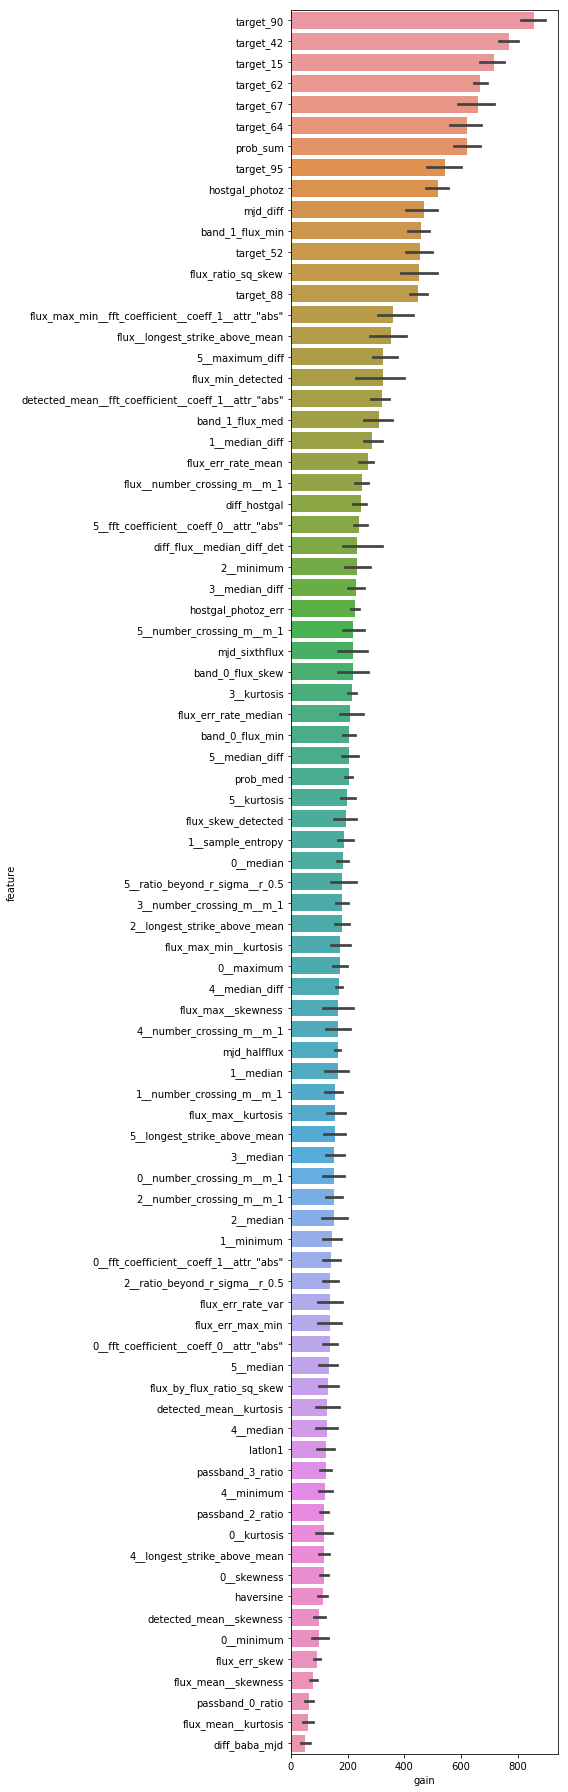

In [127]:
# v3_simple_model_importance
save_importances(importances_=importances)

In [128]:
test = pd.read_pickle('../input/test_meta_add_feature.pickle')

In [129]:
preds_ = preds_merge

In [50]:
preds_.values.shape[0]

3492890

In [130]:
preds_99 = np.ones(preds_.values.shape[0])
for i in range(preds_.shape[1]):
    preds_99 *= (1 - preds_.values[:, i])

# Create DataFrame from predictions
preds_df_ = pd.DataFrame(preds_, columns=['class_' + str(s) for s in clfs[0].classes_])
preds_df_['object_id'] = test['object_id']
preds_df_['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 

In [131]:
exgal_cols = ["class_15","class_42","class_52","class_62","class_64","class_67","class_88","class_90","class_95"]
gal_cols = ["class_6","class_16","class_53","class_65","class_92"]
total_cols = ["class_6","class_15","class_16","class_42","class_52","class_53","class_62","class_64","class_65","class_67","class_88","class_90","class_92","class_95"]

In [132]:
# post process
pred_hostgal = pd.merge(preds_df_,test[['object_id','hostgal_photoz']],on='object_id',how='left')

pred_gal = pred_hostgal[pred_hostgal['hostgal_photoz']==0].copy()
pred_gal[exgal_cols]=0

pred_ex_gal = pred_hostgal[pred_hostgal['hostgal_photoz']!=0].copy()
pred_ex_gal[gal_cols]=0

pred = pred_gal.append(pred_ex_gal)

In [133]:
del pred['hostgal_photoz']
result = pred.set_index('object_id')

In [134]:
result.to_csv('../output/predictions_1216_v5.csv', float_format='%.6f')

In [135]:
import os
os.chdir('/home')

In [136]:
%%bash
sh kaggle_submit_fix.sh PLAsTiCC output predictions_1216_v5.csv PLAsTiCC-2018 simple_lgb_cv_0.4845

Successfully submitted to PLAsTiCC Astronomical Classification

: not found
100%|██████████| 480M/480M [00:23<00:00, 21.1MB/s]
